In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from tqdm.autonotebook import tqdm

import numpy as np
import tensorflow as tf
from avgn.utils.paths import DATA_DIR

from avgn.datasets.nsynth import HParams, NSynthDataset
from avgn.networks.ae import AE

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### define hparams

In [3]:
hparams = HParams(  
    batch_size = 32,
    win_length = 1024,
    n_fft = 1024,
    hop_length=400,
    ref_level_db = 20,
    min_level_db = -50,
    power = 1, # for spectral inversion
    griffin_lim_iters = 50,
    spectrogram = True,
    #pad=True,
    mel = True,
    mfcc = False,
    mel_matrix_dict = {
        'num_mel_bins': 32,
        'num_spectrogram_bins' : 513,
        'sample_rate' : 16000,
        'lower_edge_hertz':125.0,
        'upper_edge_hertz':3800.0,
    }
)

### Get dataset

In [4]:
training_tfrecords = list((DATA_DIR / "tensorflow_datasets"/"nsynth").glob('**/*train.tfrecord*'))

In [5]:
dset = NSynthDataset([str(i) for i in training_tfrecords], hparams, num_parallel_calls = 24)

In [6]:
exs = iter(dset.dataset_batch)
ex = next(exs)
spec_ex = ex['spectrogram'].numpy()[0]

In [7]:
np.shape(spec_ex)

(160, 32)

In [8]:
example_data = tf.expand_dims(next(iter(dset.dataset_batch))['spectrogram'], axis=3)

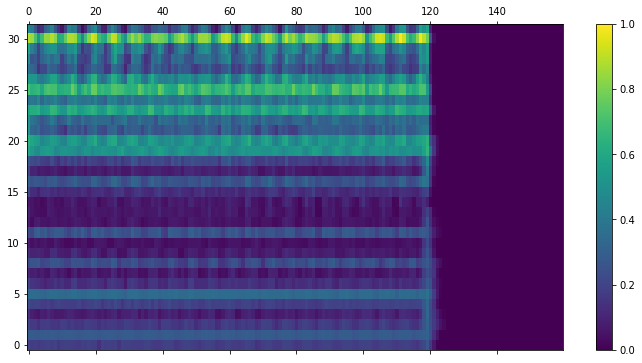

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
cset1 = ax.matshow(np.squeeze(example_data.numpy()[0]).T, aspect='auto', origin='lower')
fig.colorbar(cset1, ax=ax)

In [10]:
list(example_data.shape)

[32, 160, 32, 1]

### Make network

In [11]:
from tensorflow.keras.layers import (
    RepeatVector,
    Dense,
    TimeDistributed,
    Conv1D,
    Conv2D,
    Reshape,
    Bidirectional
)  # , LSTM
from tensorflow.python.keras.layers.recurrent import UnifiedLSTM as LSTM
#from tensorflow.keras.layers import CuDNNLSTM as LSTM

In [12]:
seq_len = 10 # the number of items in the sequence, which is determined by convolutional downsampling
spec_chans_last = 4

In [13]:
enc = [
        tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=6,
            strides=(4, 2),
            activation="relu",
            padding="same",
        ),
        tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=3,
            strides=(2, 2),
            activation="relu",
            padding="same",
        ),
        tf.keras.layers.Conv2D(
            filters=128,
            kernel_size=3,
            strides=(2, 2),
            activation="relu",
            padding="same",
        ),
        Reshape(target_shape=(seq_len, spec_chans_last*128)),
        Bidirectional(LSTM(units=100, activation="relu")),
        Dense(units=512)
    ]

W0506 16:06:18.876088 140692365756160 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ff4a80e90f0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0506 16:06:18.886038 140692365756160 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ff4a80e9780>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [14]:
dec = [
        Dense(units=512),
        RepeatVector(seq_len),
        Bidirectional(LSTM(units=100, activation="relu", return_sequences=True)),
        TimeDistributed(Dense(spec_chans_last * 128)), # features times the number of filters
        Reshape(target_shape=(seq_len, spec_chans_last, 128)),
        tf.keras.layers.Conv2DTranspose(
            filters=128,
            kernel_size=6,
            strides=(4, 2),
            padding="SAME",
            activation="relu",
        ),
        tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=3,
            strides=(2, 2),
            padding="SAME",
            activation="relu",
        ),
        tf.keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=3,
            strides=(2, 2),
            padding="SAME",
            activation="relu",
        ),
        tf.keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=3,
            strides=(1, 1),
            padding="SAME",
            activation="sigmoid",
        ),
        Reshape(target_shape=(160, 32, 1)),
    ]

W0506 16:06:18.968200 140692365756160 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ff5709656d8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0506 16:06:18.971806 140692365756160 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ff570965cf8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [15]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
model = AE(
    enc = enc,
    dec = dec,
    optimizer = optimizer
)

In [17]:
ex_z = model.encode(example_data)
print(ex_z.shape)

(32, 512)


In [18]:
np.max((ex_z.numpy()))

0.03302204

In [19]:
ex_x = model.decode(ex_z)
print(ex_x.shape)

(32, 160, 32, 1)


In [20]:
examp = next(iter(dset.dataset_batch))['spectrogram']

In [21]:
example_loss = []

nan


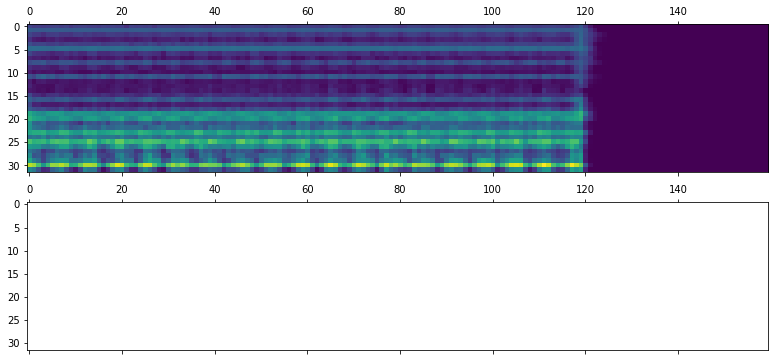

nan


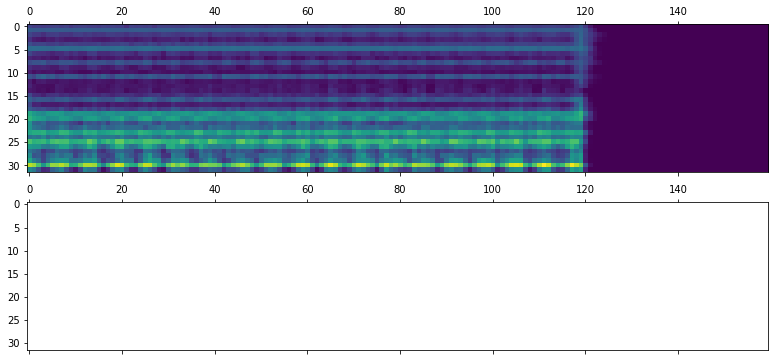

KeyboardInterrupt: 

In [22]:
for epoch in range(100): 
    txi = 0
    for train_x in tqdm(dset.dataset_batch):
        gradients = model.compute_gradients(tf.expand_dims(train_x['spectrogram'], axis=3))
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 
        txi +=1
        if (txi % 100 == 0): 
            if (txi % 1000 == 0):
                display.clear_output(wait=False)
                plt.plot(example_loss)
                plt.show()
            example_loss.append(model.compute_loss(example_data).numpy())
            print(example_loss[-1])
            recon = model.decode(model.encode(example_data))
            
            fig, axs = plt.subplots(nrows =2, figsize=(16,6))
            axs[0].matshow(np.squeeze(example_data.numpy()[0]).T, vmin=0, vmax=1)
            axs[1].matshow(np.squeeze(recon.numpy()[0]).T, vmin=0, vmax=1)
            plt.show()

    